In [568]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def show_cv2(img):
    # swap b and r channels
    b, g, r = cv2.split(img)
    img = cv2.merge([r,g,b])

#     plt.figure(figsize=(10, 10))
    plt.imshow(img)
    plt.show()

def rand_color():
    def component():
        return random.randint(0,255)
    return (component(), component(), component())

def compute_line(p1, p2):
    A = (p1[1] - p2[1])
    B = (p2[0] - p1[0])
    C = (p1[0]*p2[1] - p2[0]*p1[1])
    return A, B, -C

def line_intersection(p1, p2):
    L1 = compute_line(p1[:2], p1[2:4])
    L2 = compute_line(p2[:2], p2[2:4])

    d  = L1[0] * L2[1] - L1[1] * L2[0]
    dx = L1[2] * L2[1] - L1[1] * L2[2]
    dy = L1[0] * L2[2] - L1[2] * L2[0]
    if d != 0:
        x = dx / d
        y = dy / d
    else:
        # assume negative coordinates are invalid
        x = -1
        y = -1
    return np.asarray((x,y))

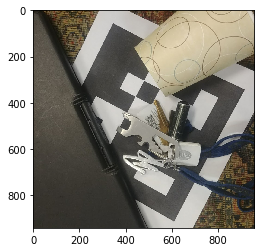

[21 95 35]


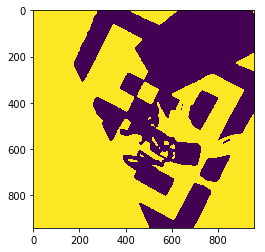

0.80976564
3.0957448
xxx
1.5869687
0.7907049
1.5647862
1.552147
1.5725161
1.593736


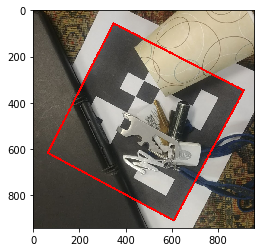

In [578]:

img = cv2.imread('occluded4.jpg')

img_height, img_width, _ = img.shape
img_diag = int(np.sqrt(img_height ** 2 + img_width ** 2))
show_cv2(img)
img_size = np.linalg.norm(img.shape)

img_blur = img
blur_size = 1 + 2 * int(img_size / 100)
if blur_size > 1:
    blur_size = (blur_size, blur_size)
    img_blur = cv2.GaussianBlur(img, blur_size, 0)
img_hsv = cv2.cvtColor(img_blur, cv2.COLOR_BGR2HSV)
print(img_hsv[0,0])

#img = cv2.resize(img,(500,500))
thresh = np.zeros(img.shape[:2], dtype=np.uint8)
thresh[img_hsv[:,:,2] <= 127] = 255
thresh[img_hsv[:,:,1] >= 127] = 255

# kernel = np.ones((10,10),np.uint8)
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
# thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)

# nb_components, output, stats, centroids = cv2.connectedComponentsWithStats(thresh, connectivity=4)

# # minimum size of particles we want to keep (number of pixels)
# #here, it's a fixed value, but you can set it as you want, eg the mean of the sizes or whatever
# min_size = (img_width * img_height) // 10

# #your answer image
# thresh = np.zeros((output.shape), dtype=np.uint8)
# #for every component in the image, you keep it only if it's above min_size
# for i in range(1, nb_components):
#     #print(sizes[i], min_size)
#     if stats[i, 4] < min_size:
#         continue
# #     if stats[i, 0] == 0 or stats[i, 1] == 0:
# #         continue
# #     if stats[i, 0] + stats[i, 2] == img_width or stats[i, 1] + stats[i, 3] == img_height:
# #         continue
#     thresh[output == i] = 255

plt.imshow(thresh)
plt.show()

#Create default parametrization LSD
lsd = cv2.createLineSegmentDetector(cv2.LSD_REFINE_NONE)

#Detect lines in the image
lines = lsd.detect(thresh)[0] #Position 0 of the returned tuple are the detected lines
#Draw detected lines in the image
#img = lsd.drawSegments(img,lines)
valid_lines = []
for line in lines:
    x1, y1, x2, y2 = line[0]
    length = np.linalg.norm([x1 - x2, y1 - y2])
    if length < img_diag / 10:
        continue

    avg_x = (x1 + x2) / 2
    avg_y = (y1 + y2) / 2

    m_x = img_width / 2 - avg_x
    m_y = img_height / 2 - avg_y
    m_x /= np.linalg.norm([m_x, m_y])
    m_y /= np.linalg.norm([m_x, m_y])
    
    def get_v(l):
        return img_hsv[int(avg_y + m_y * l), int(avg_x + m_x * l), 2]
    if get_v(5) > get_v(-5):
        continue
    valid_lines.append(line[0])

valid_lines.sort(key=lambda l: -(l[0] ** 2 + l[1] ** 2))

points = []
def vote_point(new_p, weight):
    for i in range(len(points)):
        p = points[i][0]
        old_weight = points[i][1]
        if np.linalg.norm(p - new_p) < 20:
            p *= old_weight / (weight + old_weight)
            p += new_p * weight / (weight + old_weight)
            points[i][1] += weight
            return
    points.append([new_p, weight])

for line_index, line in enumerate(valid_lines):
    x1, y1, x2, y2 = line
    p1 = np.asarray([x1, y1])
    p2 = np.asarray([x2, y2])

    slope = p2 - p1
    length = np.linalg.norm(slope)
    slope /= length
    #angle = np.arctan2(diff[1], diff[0])


    vote_point(p1, length)
    vote_point(p2, length)
#     cv2.line(img, tuple(p1), tuple(p2), rand_color(), 20)
    
    for other_line in valid_lines[line_index + 1:]:
        if line is other_line:
            continue

        ox1, oy1, ox2, oy2 = other_line
        op1 = np.asarray([ox1, oy1])
        op2 = np.asarray([ox2, oy2])
        
        oslope = op2 - op1
        olength = np.linalg.norm(oslope)
        oslope /= olength
        #oangle = np.arctan2(odiff[1], odiff[0])
        
        intersection = line_intersection(line, other_line)
        if 0 <= intersection[0] < img_width and 0 <= intersection[1] <= img_height and np.abs(slope @ oslope) < 0.5:
            vote_point(intersection, max([length, olength]))

done = False
while done == False:
    points.sort(key=lambda p: -p[1])
    final_points = points[:4]
    final_points.sort(key=lambda p: np.arctan2(p[0][1] - img_height / 2, p[0][0] - img_width / 2))
    
    done = True
    for i in range(4):
        v1 = (final_points[i][0] - final_points[i - 1][0]).astype(np.float32)
        v2 = (final_points[i][0] - final_points[(i + 1) % len(final_points)][0]).astype(np.float32)
        v1 /= np.linalg.norm(v1)
        v2 /= np.linalg.norm(v2)
        theta = np.arccos(v1 @ v2)
        print(theta)
        if theta < np.pi / 20 or theta > np.pi * 19 / 20:
            print("xxx")
            done = False
            # a bit hacky
            final_points[i][-1] = -1

final_points = np.asarray([p[0] for p in final_points], dtype=np.int32)

cv2.drawContours(img, [final_points], 0, (0,0,255), 8)
# for p in final_points:
#     print(p)
#     cv2.circle(img, tuple(p), int(img_size / 200) + 3, rand_color(), thickness=5)

# _, contours, hier = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
# for cnt in contours:
#     if cv2.contourArea(cnt) < img_height * img_width // 10:  # remove small areas like noise etc
#         continue
#     print(cv2.contourArea(cnt), img_height * img_width)
#     hull = cv2.convexHull(cnt)    # find the convex hull of contour
#     hull = cv2.approxPolyDP(hull,0.01 * cv2.arcLength(hull,True),True)
#     if len(hull) == 4:
#         cv2.drawContours(img,[hull],0,(0,0,255),5)

# gray = np.mean(img, axis=2, dtype=np.uint8)
# dst = cv2.cornerHarris(thresh, 2, 3, 0.04)
# corners = cv2.findNonZero((dst > 0.2 * dst.max()).astype(np.uint8))

# filtered_corners = []
# for corner in corners:
#     corner = tuple(corner[0])
#     x, y = corner
#     padding = 0.15
#     if (x > padding * img_width and x < (1 - padding) * img_width) \
#          and (y > padding * img_height and y < (1 - padding) * img_height):
#         continue
    
#     filtered_corners.append(corner)
#     def component():
#         return random.randint(0,255)
#     col = (component(), component(), component())

#     cv2.circle(img, corner, int(img_size / 200) + 3, col, thickness=1)
# print(len(filtered_corners))

#result is dilated for marking the corners, not important

# Threshold for an optimal value, it may vary depending on the image.
# img[dst>0.01*dst.max()]=[0,0,255]

# image,contours,hier = cv2.findContours(thresh,cv2.RETR_LIST,cv2.CHAIN_APPROX_SIMPLE)

# edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
# kernel = np.ones((3,3),np.uint8)
# edges = cv2.morphologyEx(thresh, cv2.MORPH_GRADIENT, kernel)
# plt.imshow(edges)
# lines = cv2.HoughLines(edges, 1, np.pi/180, 200)
# print(len(lines))
# for line in lines:
#     for rho,theta in line:
#         a = np.cos(theta)
#         b = np.sin(theta)
#         x0 = a*rho
#         y0 = b*rho
#         x1 = int(x0 + 1000*(-b))
#         y1 = int(y0 + 1000*(a))
#         x2 = int(x0 - 1000*(-b))
#         y2 = int(y0 - 1000*(a))

#         cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)

# edges = cv2.Canny(thresh, 50, 150, apertureSize=3)
# plt.imshow(edges)
# minLineLength = 2
# maxLineGap = 20
# lines = cv2.HoughLinesP(edges,1,np.pi/180,20,minLineLength,maxLineGap)
# for line in lines:
#     for x1,y1,x2,y2 in line:
#         cv2.line(img,(x1,y1),(x2,y2),(0,255,0),2)


show_cv2(img)